Homework 5:  CSCI 6364/4364

In this assignment, you will become familiar with the deep learning library Pytorch through the construction of a feed-forward neural network and a convolutional neural network applied to the MNIST dataset.  In various parts of the notebook, there will be places to fill in.

In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
SEED = 1
torch.manual_seed(SEED)

device = torch.device("cuda:0" if cuda else "cpu")
if cuda:
    torch.cuda.manual_seed(SEED)

Download and use the MNIST dataset from Homework 1.

In [2]:
dataset_filename = "data_mnist.csv"
df = pd.read_csv(dataset_filename)
print(df.shape)

(42000, 785)


In [3]:
# I will use my own data-loading, which I used for the mnist dataset in previous homeworks
def import_data(fname):
    data_arr = []

    with open(fname) as csv_file:
        data_reader = csv.reader(csv_file, delimiter=',')
        for row in data_reader:
            data_arr.append(row)
    return data_arr

In [4]:
data_arr = import_data("data_mnist.csv")
y =  np.array([int(e[0]) for e in data_arr[1::]])
X =  np.array([np.array(e[1::], dtype='uint8') for e in data_arr[1::]])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [5]:
print(y_test.shape)
print(X_test.shape)

(6300,)
(6300, 784)


In [6]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor).to(device) # need .to(device) to actually use cuda?
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor).to(device) 
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [7]:
input_dim = 784
output_dim = 10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,output_dim)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
 
mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    EPOCHS = 5
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [9]:
mlp = mlp.to(device) # need to specify the device for the model itself?
fit(mlp, train_loader)

Epoch : 0 [0/35700 (0%)]	Loss: 14.431194	 Accuracy:9.375%
Epoch : 0 [1600/35700 (4%)]	Loss: 0.538039	 Accuracy:68.260%
Epoch : 0 [3200/35700 (9%)]	Loss: 0.404149	 Accuracy:76.269%
Epoch : 0 [4800/35700 (13%)]	Loss: 1.032198	 Accuracy:80.091%
Epoch : 0 [6400/35700 (18%)]	Loss: 0.186923	 Accuracy:82.167%
Epoch : 0 [8000/35700 (22%)]	Loss: 0.226431	 Accuracy:83.503%
Epoch : 0 [9600/35700 (27%)]	Loss: 0.206797	 Accuracy:84.593%
Epoch : 0 [11200/35700 (31%)]	Loss: 0.391301	 Accuracy:85.390%
Epoch : 0 [12800/35700 (36%)]	Loss: 0.791081	 Accuracy:86.027%
Epoch : 0 [14400/35700 (40%)]	Loss: 0.467837	 Accuracy:86.662%
Epoch : 0 [16000/35700 (45%)]	Loss: 0.553463	 Accuracy:87.138%
Epoch : 0 [17600/35700 (49%)]	Loss: 0.209098	 Accuracy:87.704%
Epoch : 0 [19200/35700 (54%)]	Loss: 0.091053	 Accuracy:88.124%
Epoch : 0 [20800/35700 (58%)]	Loss: 0.350644	 Accuracy:88.470%
Epoch : 0 [22400/35700 (63%)]	Loss: 0.268430	 Accuracy:88.730%
Epoch : 0 [24000/35700 (67%)]	Loss: 0.151700	 Accuracy:88.994%
Epoch

1
tensor(1, device='cuda:0')


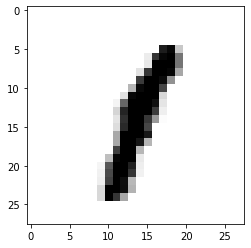

In [10]:
mlp.eval()              # turn the model to evaluate mode
index = 200
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor).to(device)
image = torch_X_test[index].float().unsqueeze(0)
true_label = y_test[index]
with torch.no_grad():     # does not calculate gradient
    class_index = mlp(image).argmax()   #gets the prediction for the image's class
plt.imshow(image.cpu().numpy().reshape(28,28), cmap='gray_r'); # need to reshape to (28, 28) rather than (28, 28, 1), and use .cpu() to go back from cuda to numpy ?
print(true_label)
print(class_index)

In [11]:
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([35700, 1, 28, 28])
torch.Size([6300, 1, 28, 28])


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
cnn = CNN().to(device)
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([32, 10])


In [13]:
fit(cnn,train_loader)

Epoch : 0 [0/35700 (0%)]	Loss: 18.775633	 Accuracy:0.000%
Epoch : 0 [1600/35700 (4%)]	Loss: 1.782842	 Accuracy:17.647%
Epoch : 0 [3200/35700 (9%)]	Loss: 1.383891	 Accuracy:30.600%
Epoch : 0 [4800/35700 (13%)]	Loss: 0.864492	 Accuracy:41.556%
Epoch : 0 [6400/35700 (18%)]	Loss: 0.656621	 Accuracy:50.093%
Epoch : 0 [8000/35700 (22%)]	Loss: 0.441207	 Accuracy:55.914%
Epoch : 0 [9600/35700 (27%)]	Loss: 0.556965	 Accuracy:60.413%
Epoch : 0 [11200/35700 (31%)]	Loss: 0.630217	 Accuracy:63.515%
Epoch : 0 [12800/35700 (36%)]	Loss: 0.621140	 Accuracy:66.365%
Epoch : 0 [14400/35700 (40%)]	Loss: 0.563681	 Accuracy:68.598%
Epoch : 0 [16000/35700 (45%)]	Loss: 0.980275	 Accuracy:70.553%
Epoch : 0 [17600/35700 (49%)]	Loss: 0.319063	 Accuracy:72.142%
Epoch : 0 [19200/35700 (54%)]	Loss: 0.565857	 Accuracy:73.445%
Epoch : 0 [20800/35700 (58%)]	Loss: 0.232893	 Accuracy:74.693%
Epoch : 0 [22400/35700 (63%)]	Loss: 0.181844	 Accuracy:75.785%
Epoch : 0 [24000/35700 (67%)]	Loss: 0.253259	 Accuracy:76.714%
Epoch

9
tensor(9, device='cuda:0')


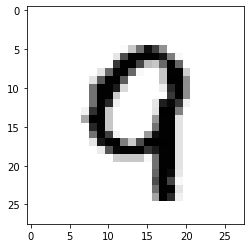

In [14]:
cnn.eval()              # turn the model to evaluate mode
index = 100
torch_X_test = torch_X_test.view(-1,1,28,28).float().type(torch.LongTensor).to(device)
image = torch_X_test[index].float().unsqueeze(0)
true_label = y_test[index]
with torch.no_grad():     # does not calculate gradient
    class_index = cnn(image).argmax()   #gets the prediction for the image's class
plt.imshow(image.cpu().numpy().reshape(28,28), cmap='gray_r');
print(true_label)
print(class_index)

Describe the performance of the MLP and CNN models? Performance can include training time, accuracy, etc.

As we can see, the MLP model performs with about the same accuracy as the CNN model. This is actually quite surprising, as I would expect the CNN to perform better in regards to accuracy as it encodes spatial information much better (but I guess since the mnist dataset is normalized, it doesn't make too much of a difference). In terms of performance, it was as expected, with the CNN having a shorter training time. Since the MLP has fully connected hidden layers, it will have many more parameters than the much more efficient CNN. Overall, the performance of the MLP and CNN are very similar, since the MNIST dataset does not contain temporal or spatial dependencies, and is completely normalized in terms of the pixels. However, the connections in the layers of the MLP increase the training time over the CNN.

Extra Credit: Describe the below code and the output

The code first selects a training sample, then outputs the class of the selected training sample. Then, the code gets the vector of predictions for each class (size 10, logits), and selects the one with highest probability. Then, the code enters the loop and set the highest probability index in the logit vector to -99 (very low), then it performs a gradient calculation on the loss between the original vector and the new vector. Then, in a forward pass, it updates the data in the x tensor with the calculated gradient and using the learning rate defined. Then, it prints the loss, highest probability from the first logit vector, and the highest probability from the new logit vector. Finally, it resets the gradient, subtracts the lowest value in the vector, and divides by the max value in the vector. Then, the loop runs but ends because the new max probability in the logit vector has changed.

Init idx: 9
tensor([-9.2215e+00, -1.4424e+01, -1.1436e+01, -1.0727e+01, -4.4189e+00,
        -9.7064e+00, -1.4597e+01, -8.8746e+00, -8.1842e+00, -1.2740e-02],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
4.40618896484375 -0.012740408070385456 -4.418929576873779

tensor(0.0039, device='cuda:0')
tensor([-2.2003, -2.1637, -2.2784, -2.2960, -2.4335, -2.4191, -2.5590, -2.3052,
        -2.1511, -2.2925], device='cuda:0', grad_fn=<SqueezeBackward0>)
Job done, breaking
tensor([-2.2003, -2.1637, -2.2784, -2.2960, -2.4335, -2.4191, -2.5590, -2.3052,
        -2.1511, -2.2925], device='cuda:0')


8

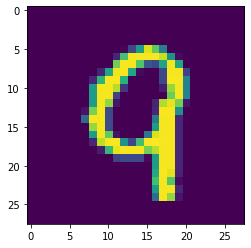

In [24]:
model = cnn
#torch_X_test = torch_X_test.view(-1,1,28,28).float().type(torch.LongTensor)
x = torch_X_test[index].float().clone()
x.requires_grad_(True)
#print(x.shape)
with torch.no_grad():
    logits = model(x.unsqueeze(0)).squeeze()
    #print(logits.shape)
    IMX = torch.argmax(logits)
print("Init idx:",IMX.item())
    
lr=.01 # learning rate?
while True:
    logits = model(x.unsqueeze(0)).squeeze()
    print(logits)
    
    imx = torch.argmax(logits)
    #print(imx)
    if imx!=IMX: 
        print("Job done, breaking")
        break
    y = logits.clone()
    y[imx] = -99
    loss = logits.max() - y.max() 
    loss.backward()
    
    #print(x.data.shape)
    x.data.sub_(lr*x.grad.data)
    print(loss.item(),logits.max().item(), y.max().item() )
    print()
    x.grad.data.zero_()
    print(1/x.data.max())
    x.data.sub_(x.data.min())
    x.data.mul_(1/x.data.max())
    
with torch.no_grad():
    print(model(x.unsqueeze(0)).squeeze())

plt.imshow(x.detach().cpu().numpy().transpose(1,2,0).reshape(28,28));torch.argmax(model(x.unsqueeze(0))).item()